In [1]:
import sys
import os
import numpy as np
import napari
%matplotlib inline
from matplotlib import pyplot as plt  # graphic library, for plots
#import seaborn as sns
import numba as nb

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure, show
from bokeh.sampledata.stocks import AAPL

In [2]:
output_notebook()

Loading BokehJS ...

In [8]:
import filedialogs

In [4]:
from metavision_core.event_io.raw_reader import RawReader
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io import EventsIterator

In [10]:
path = filedialogs.gui_fname('example_data/')
path = path.decode('ascii')

In [11]:
record_raw = RawReader(path)
print(record_raw)

RawReader(C:/Users/B0067-WS-2/Documents/code/github-ffvoigt/accordion/playground/example_data/fish_bouts_recording_2023-06-27_10-42-58.raw)
current time : 0us done : False
current event index : 0
_begin_buffer 0,_end_buffer_ 0,  buffer_size 10000000


In [12]:
events = record_raw.load_n_events(1000000)
print(events)

[(834, 596, 1,     8214) (925,   4, 0,     9194) (767, 127, 0,     9410)
 ... (829, 542, 0, 15191063) (771, 162, 0, 15191064)
 (810, 484, 0, 15191067)]


In [13]:
events['t'].max()

15191067

In [14]:
minievents = events[1:10]

In [15]:
for event in minievents:
    print(event[0])

925
767
1188
312
292
92
1104
229
1033


In [16]:
def calculate_bins(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    interval_us = max_timepoint-min_timepoint
    timepoints = int(interval_us / (dt))
    bins = np.linspace(min_timepoint, max_timepoint, timepoints)
    return bins

def calculate_bin_number(events, dt=1000):
    # calculate events for timestep dt in us
    min_timepoint = events['t'].min()
    max_timepoint = events['t'].max()
    timepoints = int(np.floor((max_timepoint-min_timepoint) / (dt)))
    return timepoints

In [19]:
@nb.njit
def inside_circle(x, y, x_center, y_center, r):
    return np.power(x-x_center,2)+np.power(y-y_center,2) <= np.power(r,2)

def is_on_event(event):
    return event[2]==1

@nb.njit
def filter_array(arr, condition):
    result = np.empty_like(arr)
    j = 0
    for i in range(arr.size):
        if condition(arr[i]):
            result[j] = arr[i]
            j += 1
    return result[:j].copy()

In [20]:
@nb.njit
def events_inside_circular_roi(events, x_center, y_center, radius):
    result = np.empty_like(events)
    j = 0
    for i in range(events.size):
        if inside_circle(events[i]['x'],events[i]['y'],x_center,y_center, radius):
            result[j] = events[i]
            j += 1
    return result[:j].copy()

In [21]:
@nb.njit
def split_events(events):
    on_events = np.empty_like(events)
    off_events = np.empty_like(events)
    on_counter = 0
    off_counter = 0
    
    for i in range(events.size):
        if events[i][2]==1:
            on_events[on_counter] = events[i]
            on_counter += 1
        else: 
            off_events[off_counter] = events[i]
            off_counter += 1
   
    return on_events[:on_counter].copy(),off_events[:off_counter].copy()

In [28]:
def viz_events(events, height, width):
    img = np.full((height, width, 3), 128, dtype=np.uint8)
    img[events['y'], events['x']] = 255 * events['p'][:, None]
    return img

In [22]:
on_events, off_events = split_events(events)

In [23]:
print(len(events))
print(len(on_events))
print(len(off_events))
print(len(off_events)+len(on_events))

236083
98758
137325
236083


In [24]:
len(events)

236083

In [25]:
inside_events = events_inside_circular_roi(events, 560, 375,350)
on_events, off_events = split_events(inside_events)

In [26]:
len(inside_events)

222401

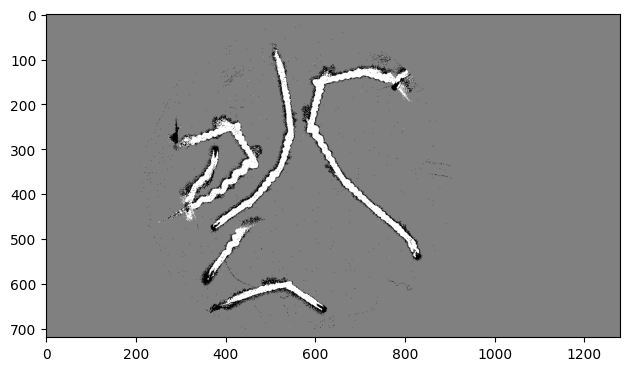

In [29]:
height, width = record_raw.get_size()

# load the next 50 ms worth of events
# events = record_raw.load_delta_t(50000)
im = viz_events(inside_events, height, width)

plt.imshow(im)
plt.tight_layout()

In [30]:
bins = calculate_bin_number(events, dt=1000)

In [31]:
bins

15182

In [32]:
len(events)

236083

In [33]:
events[0:3]

array([(834, 596, 1, 8214), (925,   4, 0, 9194), (767, 127, 0, 9410)],
      dtype={'names': ['x', 'y', 'p', 't'], 'formats': ['<u2', '<u2', '<i2', '<i8'], 'offsets': [0, 2, 4, 8], 'itemsize': 16})

Note: The on/off edges are slightly different as the event timestamps are slightly different 
* might be solvable by shifting the first and the last events in time?
* or hardcoding the edges based on the original event data?

In [34]:
on_hist, on_edges = np.histogram(on_events['t'], density=False, bins=bins)
off_hist, off_edges = np.histogram(off_events['t'], density=False, bins=bins)

In [35]:
len(off_edges)

15183

In [36]:
on_hist[8170]

144

In [37]:
off_hist[8170]

162

### First working version of a time selector

In [46]:
source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

p = figure(height=400, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(on_edges[8150], on_edges[8350]))

p.quad(top=off_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="darkred", line_width=0, legend_label="Off Events")
p.quad(top=on_hist+off_hist, bottom=off_hist, left=on_edges[:-1], right=on_edges[1:],
         fill_color="royalblue", line_width=0, legend_label="On Events")
p.y_range.start = 0
p.xaxis.axis_label = "t (us)"
p.yaxis.axis_label = "Events"
p.legend.location = "top_right"


select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(p, select))

In [107]:
source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

p = figure(title="Event Plot", height=400, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(on_edges[8150], on_edges[8350]))

p.varea_stack(['on_hist', 'off_hist'], x='edges', color=("blue", "red"), source=source)

p.y_range.start = 0

p.xaxis.axis_label = "t (us)"
p.yaxis.axis_label = "Events"
#p.legend.location = "top_right"


select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(p, select))

### Stacked view

In [44]:
source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

p = figure(height=300, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(on_edges[8150], on_edges[8350]))

p.quad(top=off_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="darkred", line_width=0)
p.y_range.start = 0
p.yaxis.axis_label = "Off Events"

q = figure(height=300, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(on_edges[8150], on_edges[8350]))
q.quad(top=on_hist, bottom=0, left=on_edges[:-1], right=on_edges[1:],
         fill_color="royalblue", line_width=0)
q.xaxis.axis_label = "t (us)"
q.yaxis.axis_label = "On Events"

select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)

show(column(q, p, select))

### Let's try an event scatterplot!

In [65]:
on_minievents = on_events[8150:8350]
off_minievents = off_events[8150:8350]

In [71]:
p = figure(width=640, height=360)

# add a circle renderer with a size, color, and alpha

p.dot(on_minievents['x'], on_minievents['y'], size=5, color="blue", alpha=0.8)
p.dot(off_minievents['x'], off_minievents['y'], size=5, color="red", alpha=0.8)
p.y_range.flipped = True

# show the results
show(p)

In [110]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
# output_notebook()

source = ColumnDataSource(data=dict(edges=on_edges[:-1], on_hist=on_hist, off_hist=off_hist))

scatterplot = figure(height=700, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef")
scatterplot.y_range.flipped = True
scatterplot.dot(on_events['x'], on_events['y'], size=5, color="blue", alpha=0.8)
scatterplot.dot(off_events['x'], off_events['y'], size=5, color="red", alpha=0.8)

p = figure(height=400, width=950, tools="xpan", toolbar_location=None,
           x_axis_location="below", background_fill_color="#efefef",x_range=(on_edges[8150], on_edges[8350]))

p.varea_stack(['on_hist', 'off_hist'], x='edges', color=("blue", "red"), source=source)
p.y_range.start = 0
p.xaxis.axis_label = "t (us)"
p.yaxis.axis_label = "Events"
#p.legend.location = "top_right"

select = figure(title="Event Selection",
                height=230, width=950, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2



# slider = Slider(start=0.1, end=4, value=1, step=.1, title="power", callback=callback)

select.line('edges', 'on_hist', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.yaxis.axis_label = "Events"



show(column(scatterplot, p, select))

NameError: name 'CustomJS' is not defined

In [88]:
from bokeh.io import curdoc
from bokeh.layouts import column, row
from bokeh.models import GMapOptions, CDSView, IndexFilter
from bokeh.models.widgets import RangeSlider
from bokeh.plotting import gmap, ColumnDataSource, figure

lon = [[48.7886, 48.7887, 48.7888, 48.7889, 48.789],
       [48.7876, 48.7877, 48.78878, 48.7879, 48.787],
       [48.7866, 48.7867, 48.7868, 48.7869, 48.786],
       [48.7856, 48.7857, 48.7858, 48.7859, 48.785],
       [48.7846, 48.7847, 48.7848, 48.7849, 48.784]]
lat = [[8.92, 8.921, 8.922, 8.923, 8.924],
       [8.91, 8.911, 8.912, 8.913, 8.914],
       [8.90, 8.901, 8.902, 8.903, 8.904],
       [8.89, 8.891, 8.892, 8.893, 8.894],
       [8.88, 8.881, 8.882, 8.883, 8.884]]
time = [0, 1, 2, 3, 4]
velocity = [23, 24, 25, 24, 20]
length_dataset = len(lon)

# define source and map
source = ColumnDataSource(data={'x': lon, 'y': lat, 't': time, 'v': velocity})
view = CDSView(filter=IndexFilter(list(range(length_dataset))))
b
map_options = GMapOptions(lat=48.7886, lng=8.92, map_type="satellite", zoom=13)

p = gmap("API_KEY", map_options, title="Trajectory Map")
v = figure(width=400, height=400, title="Velocity")

p.multi_line('y', 'x', view=view, source=source, line_width=1)
v.line('t', 'v', view=view, source=source, line_width=3)

range_slider = RangeSlider(title="Data Range Slider: ", start=0, end=length_dataset, value=(0, length_dataset), step=1)

def slider_callback(attr, old, new):
    view.filter = IndexFilter(list(range(*new)))

range_slider.on_change('value', slider_callback)

layout = row(column(p, range_slider), column(v))
curdoc().add_root(layout)

show(layout)

ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology such as Line or Patch: GlyphRenderer(id='p4279', ...)
You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



In [93]:
type(view.filter)

bokeh.models.filters.IndexFilter

In [ ]:
plt.hist(events['t'], bins=1000)

In [ ]:
intereventintervals = np.diff(events['t'])

In [ ]:
plt.hist(intereventintervals, bins=50, range=(0,50))

### Numpy arrays have names for columns!

In [ ]:
events.dtype.names

### Napari plot

In [ ]:
from skimage import data

In [ ]:
viewer = napari.Viewer()

In [ ]:
points = np.array([[1, 100, 100, 2], [2, 200, 200, 4], [3, 300, 100, 4]])

In [ ]:
points_layer = viewer.add_points(events[:10000], size=2)

In [ ]:
record_raw.get_size()